In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import copy
import json
from tqdm import tqdm
import pickle
import logging
import math
import matplotlib
# plot calibration of Copilot confidences with XGBoost predictions
from re import S
from scipy.stats.stats import pearsonr  
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

In [31]:
# open pickle logs_by_user_session_labeled
# open pickle logs_by_user_session_labeled
with open('../data/logs_by_user_session_labeled.pkl', 'rb') as f:
    logs_by_user_session_labeled = pickle.load(f)


# Time and Frequency in States

In [32]:
all_states = []
all_actions = []
all_times = []
all_states_continuous = []
all_states_list = []
all_times_list = []

all_times_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(last_state)
            last_state = states[i]
            times_continuous.append(times_cumalitive)
            times_cumalitive = times[i]
        else:
            times_cumalitive += times[i]
    states_continuous.append(last_state)
    times_continuous.append(times_cumalitive)
    
    all_states_list.extend(states)
    all_times_list.extend(times)
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)


In [33]:
# get average lenght of session
session_lengths = [ np.sum(times)/60 for times in all_times]
# avrage session length
np.mean(session_lengths)
# standard deviation of session length
np.std(session_lengths)
print(f'Average session length: {np.mean(session_lengths):.2f} +- {np.std(session_lengths):.2f}')
print(f' max lenght of session: {np.max(session_lengths):.2f} min lenght of session: {np.min(session_lengths):.2f}')

# number of events per session
session_counts_events = [len(times) for times in all_times]
print (f'Average number of events per session: {np.mean(session_counts_events):.2f} +- {np.std(session_counts_events):.2f}')
print(f'total number of events: {np.sum(session_counts_events)}')

Average session length: 12.23 +- 3.98
 max lenght of session: 20.80 min lenght of session: 5.26
Average number of events per session: 149.38 +- 57.43
total number of events: 3137


In [34]:
states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used

states_count = [[0 for i in range(len(states_unique))] for _ in range(len(all_states))]
for i in range(len(all_states)):
    for j in range(len(all_states[i])):
        states_count[i][states_unique.index(all_states[i][j])] += all_times[i][j]
# normalize
states_count = [[i/sum(states_count_single)*100 for i in states_count_single] for states_count_single in states_count]
averaged_over_users = np.mean(states_count, axis=0)
# print
print('Averaged Across Users \n \n')
for i in range(len(states_unique)):
    print(f' {states_unique[i]}  {averaged_over_users[i]:.2f}')


Averaged Across Users 
 

 Thinking About New Code To Write (F)  10.91
 Editing Written Code(C)  4.28
 Looking up Documentation (N)  7.45
 Thinking/Verifying Suggestion (A)  22.40
 Debugging/Testing Code (H)  11.31
 Waiting For Suggestion (G)  4.20
 Prompt Crafting (V)  11.56
 Writing New Functionality (Z)  14.05
 Writing Documentation (B)  0.53
 Deferring Thought For Later (D)  1.39
 Not Thinking (S)  0.00
 Editing Last Suggestion (X)  11.90


In [35]:
states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used
states_count = [0 for i in range(len(states_unique))]
states_freq = {}
for i in range(len(all_states)):
    for j in range(len(all_states[i])):
        states_count[states_unique.index(all_states[i][j])] += all_times[i][j]
# normalize
states_count = [i/sum(states_count)*100 for i in states_count]
print('Averaged Across All Sessions \n \n')
for i in range(len(states_count)):
    print(f' {states_unique[i]}  {states_count[i]:.2f}')
    states_freq[states_unique[i]] = states_count[i]

Averaged Across All Sessions 
 

 Thinking About New Code To Write (F)  12.77
 Editing Written Code(C)  4.46
 Looking up Documentation (N)  7.38
 Thinking/Verifying Suggestion (A)  21.82
 Debugging/Testing Code (H)  11.56
 Waiting For Suggestion (G)  4.59
 Prompt Crafting (V)  11.08
 Writing New Functionality (Z)  13.34
 Writing Documentation (B)  0.44
 Deferring Thought For Later (D)  1.34
 Not Thinking (S)  0.01
 Editing Last Suggestion (X)  11.22


In [36]:
# unroll all actions into one list
all_actions_unrolled = []
for i in range(len(all_actions)):
    all_actions_unrolled.extend(all_actions[i])
# count how many shown events

# histogram of actions frequency
# counterr
import collections
counter = collections.Counter(all_actions_unrolled)
# normalize counter
counter_normalized = {k: v/sum(counter.values()) for k, v in counter.items()}
print(counter)
print(f' Accept Rate is {counter["Accepted"]/ counter["Shown"]}')

Counter({'Replay': 1133, 'Shown': 1024, 'Rejected': 627, 'Accepted': 348, 'Browsing': 5})
 Accept Rate is 0.33984375


In [37]:
# get unique states
from scipy import stats as st

states_unique = list(set(all_states_continuous))
# for each state get average time spent in state
all_states_list
states_time = {}
for i in range(len(all_states_list)):
    # check if already in dict
    if all_states_list[i] in states_time:
        states_time[all_states_list[i]].append(all_times_list[i])
    else:
        states_time[all_states_list[i]] = [all_times_list[i]]
# get average time spent in state
states_time_avg = {}
for s in states_time:
    # get 90% confidence interval for states_time[s] which is a list of times
    confidence_interval = st.t.interval(0.90, len(states_time[s])-1, loc=np.mean(states_time[s]), scale=st.sem(states_time[s]))
    states_time_avg[s] = [np.mean(states_time[s]), np.median(states_time[s]), np.std(states_time[s]), confidence_interval]
# sort states by average time spent in state
# print
for s in states_time_avg:
    print(f' state {s} avg time {states_time_avg[s][0]:.2f} median time {states_time_avg[s][1]:.2f} std time {states_time_avg[s][2]:.2f}')


 state Thinking/Verifying Suggestion (A) avg time 5.29 median time 1.22 std time 11.87
 state Looking up Documentation (N) avg time 75.84 median time 62.78 std time 75.20
 state Prompt Crafting (V) avg time 1.91 median time 0.26 std time 6.86
 state Thinking About New Code To Write (F) avg time 8.27 median time 0.86 std time 22.61
 state Writing New Functionality (Z) avg time 3.03 median time 0.46 std time 8.19
 state Editing Last Suggestion (X) avg time 9.82 median time 1.14 std time 20.91
 state Debugging/Testing Code (H) avg time 13.60 median time 1.30 std time 24.57
 state Editing Written Code(C) avg time 7.16 median time 0.60 std time 21.09
 state Waiting For Suggestion (G) avg time 4.18 median time 1.03 std time 11.09
 state Writing Documentation (B) avg time 3.98 median time 0.86 std time 9.56
 state Deferring Thought For Later (D) avg time 2.41 median time 1.31 std time 3.15
 state Not Thinking (S) avg time 1.19 median time 1.19 std time 0.00


/home/hussein/miniconda3/envs/hussein2/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hussein/miniconda3/envs/hussein2/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
# get unique states
# import st
states_unique = list(set(all_states_continuous))
# for each state get average time spent in state
all_states_list
states_time = {}
for i in range(len(all_states_continuous)):
    # check if already in dict
    if all_states_continuous[i] in states_time:
        states_time[all_states_continuous[i]].append(all_times_continuous[i])
    else:
        states_time[all_states_continuous[i]] = [all_times_continuous[i]]
# get average time spent in state
states_time_avg = {}
for s in states_time:
    confidence_interval = st.t.interval(0.90, len(states_time[s])-1, loc=np.mean(states_time[s]), scale=st.sem(states_time[s]))
    if 'Not Thinking' in s:
        states_time_avg[s] = [np.mean(states_time[s]), np.median(states_time[s]), np.std(states_time[s]), (0,0)]
    else:
        states_time_avg[s] = [np.mean(states_time[s]), np.median(states_time[s]), np.std(states_time[s]), confidence_interval]
# sort states by average time spent in state
# print
for s in states_time_avg:
    print(f' state {s} avg time {states_time_avg[s][0]:.2f} median time {states_time_avg[s][1]:.2f} std time {states_time_avg[s][2]:.2f} confidence interval {states_time_avg[s][3]}')


 state Thinking/Verifying Suggestion (A) avg time 10.71 median time 4.00 std time 21.52 confidence interval (8.701528207699903, 12.714070518414744)
 state Looking up Documentation (N) avg time 113.76 median time 108.83 std time 64.78 confidence interval (74.17237939984258, 153.34142060015742)
 state Prompt Crafting (V) avg time 17.60 median time 7.50 std time 26.63 confidence interval (13.089440451741442, 22.116167795681235)
 state Thinking About New Code To Write (F) avg time 17.11 median time 6.02 std time 32.28 confidence interval (12.092446190956402, 22.119710330782727)
 state Writing New Functionality (Z) avg time 11.61 median time 5.99 std time 16.69 confidence interval (9.532307202914993, 13.69367019821495)
 state Editing Last Suggestion (X) avg time 23.36 median time 13.00 std time 30.13 confidence interval (17.480089380564788, 29.231153862678447)
 state Debugging/Testing Code (H) avg time 50.91 median time 44.44 std time 38.27 confidence interval (39.813425959256655, 62.006745

plot bar chart of time and frequency in each state

In [39]:
from hmmviz import TransGraph
import pandas as pd
import matplotlib.pyplot as plt


T = pd.crosstab(
    pd.Series(all_states_list[:-1], name='Today'),
    pd.Series(all_states_list[1:], name='Tomorrow'),
    normalize=0
)
'''
T = pd.crosstab(
    pd.Series(all_states_continuous[:-1], name='Today'),
    pd.Series(all_states_continuous[1:], name='Tomorrow'),
    normalize=0
)
'''
graph = TransGraph(T)
transition_matrix = np.array(graph.dataframe)
nodes = list(graph.dataframe.index)
# take each string in nodes and add new line if more than 2 words in string
nodes_new = []
for i in range(len(nodes)):
    if len(nodes[i].split(' ')) > 2:
        words = nodes[i].split(' ')
        temp_str = ''
        added_line = False
        for j in range(len(words)-1):
            temp_str += words[j] +' ' 
            if (j == 1 or len(temp_str)> 15) and not added_line:
                temp_str += '\n'
                added_line = True
        nodes_new.append(temp_str)
    else:
        nodes_new.append(nodes[i])
nodes = nodes_new
nodes[3] = 'Editing Written \n Code'
nodes[-2] = 'Writing \n Documentation '
labels_nodes = {}
# color nodes
frequencies = [11.31, 1.39, 11.9,4.28,7.45,0.01,11.56,10.91,22.4,4.2,0.53,14.05]
avg_times = [29.24,  7.34, 24.22, 14.08, 106.51, 11.08, 10.67, 19.67, 10.58, 10.54,  9.12, 13.60]
for i in range(len(nodes)):
    #nodes[i] = nodes[i] + f' \n {avg_times[i]:.2f}s , {frequencies[i]:.2f}per ' 
    labels_nodes[nodes[i]] = f"{nodes[i]}"#  \n {avg_times[i]:.2f}s, {frequencies[i]:.2f}/100 " 
# permute array nodes given new indices
new_permutation = [0,4,1,8,7,5,9,11,3,2,10,6] # list(range(12))#
nodes = [nodes[i] for i in new_permutation]
# new permutation is the new order for nodes
# make new transition matrix that is consistent with new permutation
transition_matrix_new = np.zeros((len(nodes),len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        transition_matrix_new[i][j] = transition_matrix[new_permutation[i]][new_permutation[j]]
transition_matrix = transition_matrix_new

from collections import namedtuple

cset = namedtuple('Mcset',
            'rose indigo sand green cyan wine teal olive purple pale_grey black white yellow')
colors = cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
            '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
            '#000000', '#FFFFFF', '#DDAA33')

color_mapping = {'Debugging/Testing Code (H)': colors.yellow, 'Deferring Thought For Later (D)': colors.cyan, 'Editing Last Suggestion (X)': colors.rose, 'Editing Written Code(C)': colors.purple, 'Looking up Documentation (N)': colors.olive, 'Not Thinking': colors.white,  'Prompt Crafting (V)': colors.indigo, 'Thinking About New Code To Write (F)': colors.teal, 'Thinking/Verifying Suggestion (A)': colors.green, 'Waiting For Suggestion (G)': colors.pale_grey, 'Writing Documentation (B)': colors.sand, 'Writing New Functionality (Z)': colors.wine}
nodes_colors = list(color_mapping.values())
edgecolors  = {k: colors.black for k in color_mapping.keys()}
nodes_colors = [nodes_colors[i] for i in new_permutation]


color_mapping['Not Thinking (S)'] = '#FFFFFF'



['Not Thinking (S)', 'Writing Documentation (B)', 'Deferring Thought For Later (D)', 'Editing Written Code(C)', 'Waiting For Suggestion (G)', 'Looking up Documentation (N)', 'Prompt Crafting (V)', 'Editing Last Suggestion (X)', 'Debugging/Testing Code (H)', 'Thinking About New Code To Write (F)', 'Writing New Functionality (Z)', 'Thinking/Verifying Suggestion (A)']


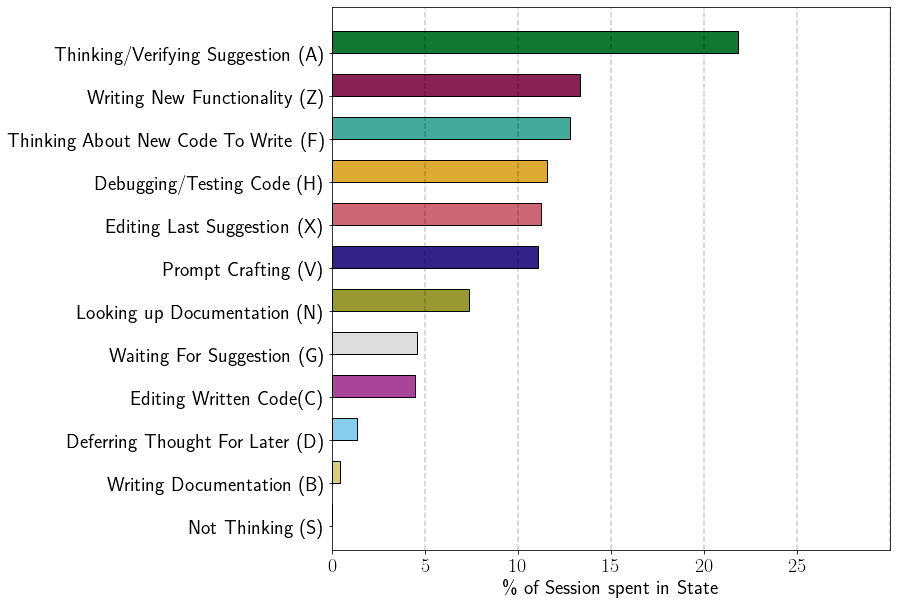

In [41]:
from tkinter import W
# sort statesfreq by frequency
statesfreq = sorted(states_freq.items(), key=lambda x: x[1], reverse=False)
# get keys sorted
statesfreq_keys = [x[0] for x in statesfreq]
print(statesfreq_keys)

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(1,1,1)
y = np.arange(12)*2
w = 0.5
plt.yticks(y  , statesfreq_keys, rotation='horizontal')
error_bars = [(states_time_avg[s][3][1]-states_time_avg[s][3][0])/2 for s in statesfreq_keys]

freq = ax1.barh(y , [states_freq[s] for s in statesfreq_keys],align='edge',  alpha=1,  height = 2*w, color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black')

#time = ax1.barh(y , [states_time_avg[s][0] for s in statesfreq_keys], align='edge', xerr= error_bars,   height = w,  color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black', )
#ax2 = ax1.twiny()
ax1.set_xlabel('\% of Session spent in State', fontsize=20)

# change font size of x axis
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
# make limit of x axis the same and 0
ax1.set_xlim(0, 30)
# more ticks for ax2
ax1.set_xticks(np.arange(0, 30, 5))
# axis titles
# legend
# show vertical lines

ax1.axvline(x=5, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=10, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=15, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=20, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=25, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=30, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=35, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=40, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=45, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=50, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=55, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=60, color='black', linestyle='--', alpha=0.2)

#plt.legend([time, freq],['Average Time in State', 'Frequency'], fontsize=20)
# save with tight   
plt.savefig('histogram.pdf',dpi=1000,  bbox_inches='tight')   

# show plot
plt.show()


['Thinking/Verifying Suggestion (A)', 'Writing New Functionality (Z)', 'Thinking About New Code To Write (F)', 'Debugging/Testing Code (H)', 'Edditing Last Suggestion (X)', 'Prompt Crafting (V)', 'Looking up Documentation (N)', 'Waiting For Suggestion (G)', 'Editing Written Code(C)', 'Deferring Thought For Later (D)', 'Writing Documentation (B)', 'Not Thinking (S)']


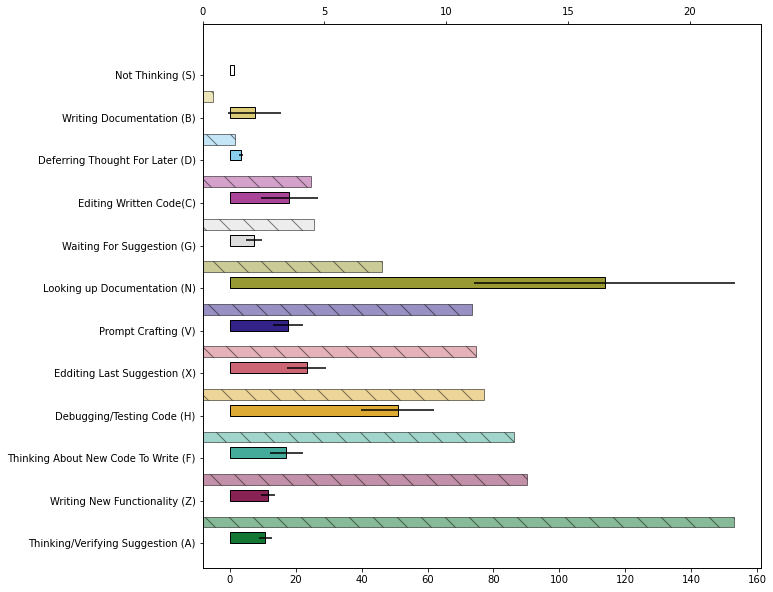

In [ ]:
# plot the above bar chart but with the states sorted by frequency
# sort statesfreq by frequency
statesfreq = sorted(states_freq.items(), key=lambda x: x[1], reverse=True)
# get keys sorted
statesfreq_keys = [x[0] for x in statesfreq]
print(statesfreq_keys)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1,1,1)
y = np.arange(12)*2
w = 0.5
plt.yticks(y  , statesfreq_keys, rotation='horizontal')
error_bars = [(states_time_avg[s][3][1]-states_time_avg[s][3][0])/2 for s in statesfreq_keys]
time = ax1.barh(y , [states_time_avg[s][0] for s in statesfreq_keys], align='edge', xerr= error_bars,   height = w,  color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black', )
ax2 = ax1.twiny()
freq = ax2.barh(y + 1.5*w, [states_freq[s] for s in statesfreq_keys],align='edge',  alpha=0.5,  height = w, color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black', hatch="\\")
# change font size of x axis


# Time Spent by State

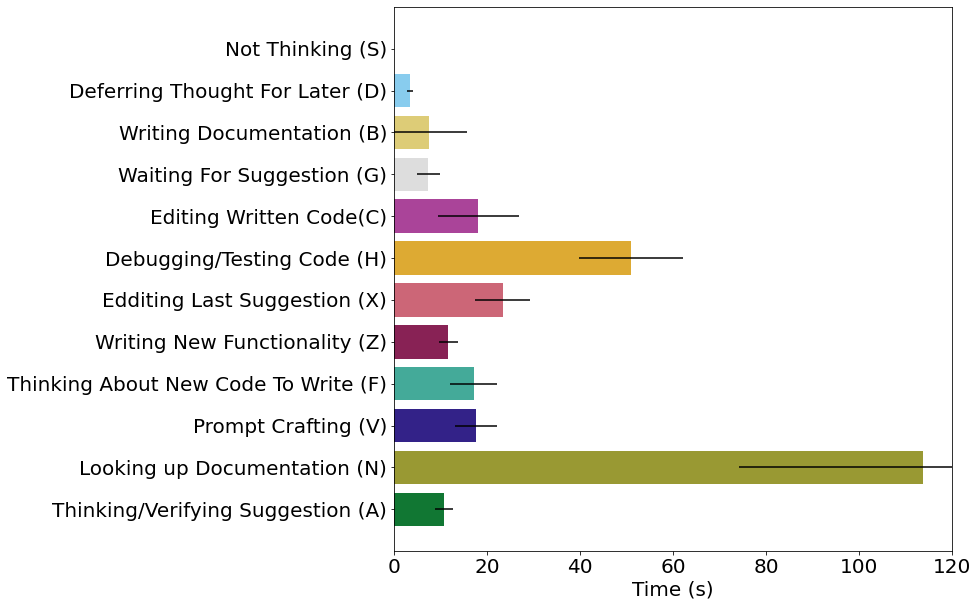

In [ ]:
# plot bar chart of state and time spent in state
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
# horizontal bar chart with error bars as 95% confidence interval
error_bars = [(states_time_avg[s][3][1]-states_time_avg[s][3][0])/2 for s in states_time_avg]
color_mapping = {'Debugging/Testing Code (H)': colors.yellow, 'Deferring Thought For Later (D)': colors.cyan, 'Editing Last Suggestion (X)': colors.rose, 'Editing Written Code(C)': colors.purple, 'Looking up Documentation (N)': colors.olive, 'Not Thinking (S)': colors.white,  'Prompt Crafting (V)': colors.indigo, 'Thinking About New Code To Write (F)': colors.teal, 'Thinking/Verifying Suggestion (A)': colors.green, 'Waiting For Suggestion (G)': colors.pale_grey, 'Writing Documentation (B)': colors.sand, 'Writing New Functionality (Z)': colors.wine}

plt.barh(list(states_time_avg.keys()), [states_time_avg[s][0] for s in states_time_avg], xerr=error_bars, color=[color_mapping[s] for s in states_time_avg], label='Time Spent in State')
# add median line

# y ticks make x-large
plt.yticks(fontsize=20)
# x ticks make x-large
plt.xticks(fontsize=20)
# show median time as a line
plt.xlabel('Time (s)', fontsize = 20)
plt.xlim(0,120)
plt.show()

Thinking/Verifying Suggestion (A)
Looking up Documentation (N)
Prompt Crafting (V)
Thinking About New Code To Write (F)
Writing New Functionality (Z)
Edditing Last Suggestion (X)
Debugging/Testing Code (H)
Editing Written Code(C)
Waiting For Suggestion (G)
Writing Documentation (B)
Deferring Thought For Later (D)
Not Thinking (S)


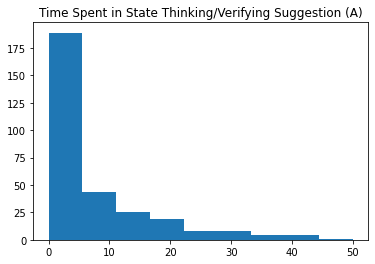

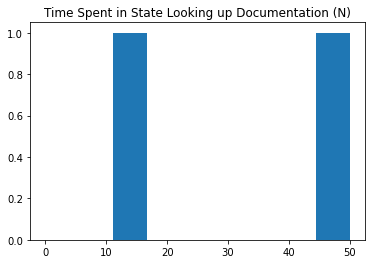

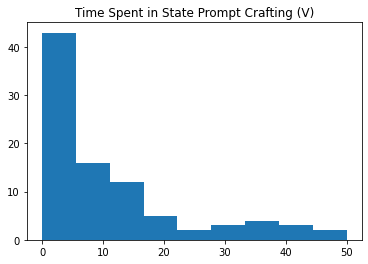

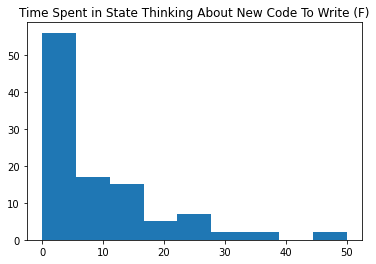

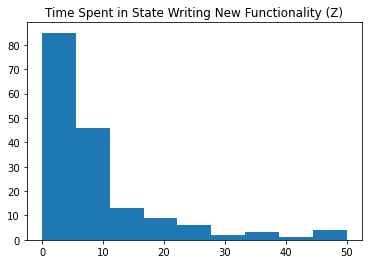

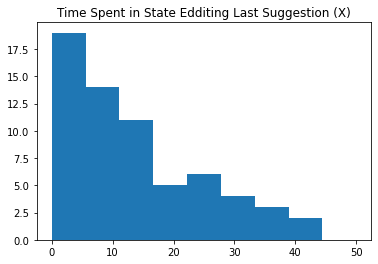

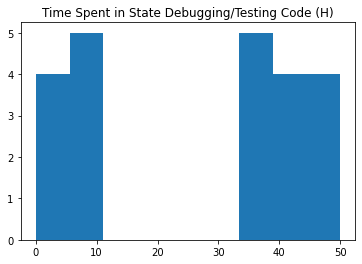

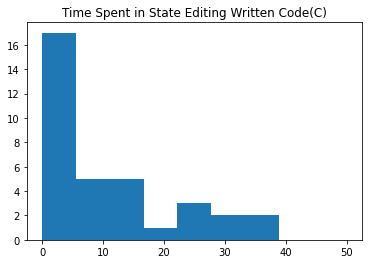

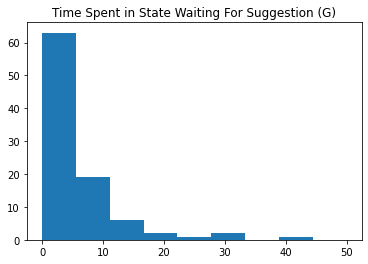

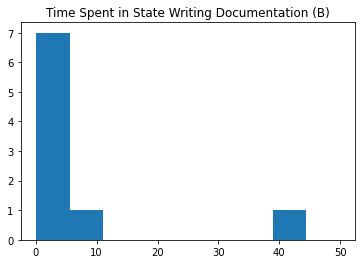

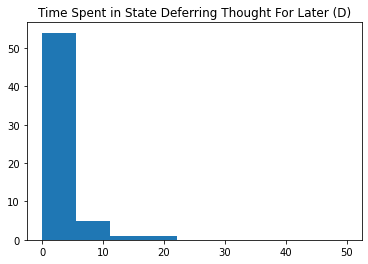

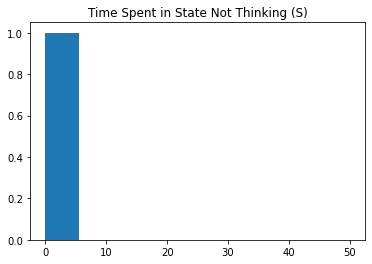

In [ ]:
# plot histograms of times
states_unique = list(set(all_states_continuous))
# for each state get average time spent in state
states_time = {}
for i in range(len(all_states_continuous)):
    # check if already in dict
    if all_states_continuous[i] in states_time:
        states_time[all_states_continuous[i]].append(all_times_continuous[i])
    else:
        states_time[all_states_continuous[i]] = [all_times_continuous[i]]
# get average time spent in state
states_time_avg = {}
for s in states_time:
    # plot histogram of time spent in state
    print(s)
    fig, ax = plt.subplots()
    ax.hist(states_time[s], density = False,  bins=np.linspace(0,50,num=10))#)np.quantile(states_time[s], np.linspace(0,1,10+1)))
    # change title
    ax.set_title(f'Time Spent in State {s}')
# sort states by average time spent in state


# Transitions and Sequences

In [ ]:
T = pd.crosstab(
    pd.Series(all_states_list[:-1], name='Today'),
    pd.Series(all_states_list[1:], name='Tomorrow'),
    normalize=0
)


graph = TransGraph(T)
nodes_original = list(graph.dataframe.index)
transition_matrix = np.array(graph.dataframe)

In [ ]:
# find most probable transition from each state
# find most probable transition from each state

for i in range(len(transition_matrix)):
    # find max value in ro
    max_val = max(transition_matrix[i])
    # find index of max value in row
    max_val_index = transition_matrix[i].tolist().index(max_val)
    # add to dict
    print(f' {nodes[i]} --- {transition_matrix[i][max_val_index]:.2f} ---> {nodes[max_val_index]}')

 Debugging/Testing 
Code  --- 0.73 ---> Debugging/Testing 
Code 
 Looking up 
Documentation  --- 0.38 ---> Editing Written 
 Code
 Deferring Thought 
For Later  --- 0.58 ---> Deferring Thought 
For Later 
 Thinking/Verifying 
Suggestion  --- 0.60 ---> Thinking/Verifying 
Suggestion 
 Thinking About 
New Code To Write  --- 0.33 ---> Thinking About 
New Code To Write 
 Not Thinking 
 --- 1.00 ---> Prompt Crafting 

 Waiting For 
Suggestion  --- 0.89 ---> Waiting For 
Suggestion 
 Writing New 
Functionality  --- 0.52 ---> Writing New 
Functionality 
 Editing Written 
 Code --- 0.51 ---> Editing Written 
 Code
 Edditing Last 
Suggestion  --- 0.43 ---> Edditing Last 
Suggestion 
 Writing 
 Documentation  --- 0.47 ---> Writing 
 Documentation 
 Prompt Crafting 
 --- 0.74 ---> Prompt Crafting 



In [ ]:
import numpy as np
import scipy.linalg


def local_entropy(P):
    """Computes the local entropy at each state of the MC defined by the transition
    probabilities P"""
    # TODO: Not optimal memory wise !!
    L = np.copy(P)
    L[P > 0] = np.log2(P[P > 0])
    K = np.dot(P, np.transpose(L))
    entropy_out = -1*np.diagonal(K)
    return entropy_out.reshape((P.shape[0], 1))


def stationary_distribution(P):
    """Computes the stationary distribution mu associated with the MC whose
    transition probabilities are given by the numpy array P
    IMPORTANT: the MC must be irreducile and aperiodic to admit a sttinary
    distribution
    """
    v = np.real(scipy.linalg.eig(P, left=True, right=False)[1][:, 0])
    mu = np.abs(v)/np.sum(np.abs(v))
    return mu


def trajectory_entropy(P):
    """Returns the matrix of trajectories entropy H associed to MC whose transition
    probabilities are given by the numpy array P.
    IMPORTANT: the MC is irreducile and aperiodic"""
    n = P.shape[0]
    mu = stationary_distribution(P)
    A = np.tile(mu, (n, 1))
    # local entropies of the MC
    l_entropy = local_entropy(P)
    H_star = np.tile(l_entropy, (1, n))
    # entropy rate
    entropy_rate = np.dot(mu.transpose(), l_entropy)
    H_delta = np.diagflat(entropy_rate/mu)
    K = np.dot(np.linalg.inv(np.identity(n) - P + A), H_star-H_delta)
    K_tilda = np.tile(np.diag(K).transpose(), (n, 1))
    H = K - K_tilda + H_delta
    return H


In [ ]:
mu = stationary_distribution(transition_matrix)
# get entropy rate of the MC
entropy_rate = np.dot(mu.transpose(), local_entropy(transition_matrix))
print(entropy_rate)

[1.1281112]


In [ ]:

uniform_transition_matrix = np.ones((len(transition_matrix), len(transition_matrix)))/len(transition_matrix)

mu = stationary_distribution(uniform_transition_matrix)
# uniform transition matrix
# get entropy rate of the MC
entropy_rate = np.dot(mu.transpose(), local_entropy(uniform_transition_matrix))
print(entropy_rate)

[3.5849625]


In [ ]:
# find most probable transition from each state
# find most probable transition from each state
nodes_original = list(graph.dataframe.index)

for i in range(len(transition_matrix)):
    # find max value in ro
    max_val = max(transition_matrix[i])
    # find index of max value in row
    max_val_index = transition_matrix[i].tolist().index(max_val)
    # add to dict
    print(f' {nodes_original[i]} --- {transition_matrix[i][max_val_index]:.2f} ---> {nodes_original[max_val_index]}')

 Debugging/Testing Code (H) --- 0.73 ---> Debugging/Testing Code (H)
 Deferring Thought For Later (D) --- 0.38 ---> Thinking/Verifying Suggestion (A)
 Edditing Last Suggestion (X) --- 0.58 ---> Edditing Last Suggestion (X)
 Editing Written Code(C) --- 0.60 ---> Editing Written Code(C)
 Looking up Documentation (N) --- 0.33 ---> Looking up Documentation (N)
 Not Thinking (S) --- 1.00 ---> Writing New Functionality (Z)
 Prompt Crafting (V) --- 0.89 ---> Prompt Crafting (V)
 Thinking About New Code To Write (F) --- 0.52 ---> Thinking About New Code To Write (F)
 Thinking/Verifying Suggestion (A) --- 0.51 ---> Thinking/Verifying Suggestion (A)
 Waiting For Suggestion (G) --- 0.43 ---> Waiting For Suggestion (G)
 Writing Documentation (B) --- 0.47 ---> Writing Documentation (B)
 Writing New Functionality (Z) --- 0.74 ---> Writing New Functionality (Z)


In [ ]:
# find most probable transition from each state
# find most probable transition from each state
nodes_original = list(graph.dataframe.index)

for i in range(len(transition_matrix)):
    # find top 2 values in row
    top_2_values = sorted(transition_matrix[i], reverse=True)[:2]
    # find indices of top 2 values in row
    top_2_values_indices = [transition_matrix[i].tolist().index(x) for x in top_2_values]

    # add to dict
    print(f' {nodes_original[i]} --- {transition_matrix[i][top_2_values_indices[1]]:.2f} ---> {nodes_original[top_2_values_indices[1]]}')

 Debugging/Testing Code (H) --- 0.08 ---> Thinking/Verifying Suggestion (A)
 Deferring Thought For Later (D) --- 0.29 ---> Deferring Thought For Later (D)
 Edditing Last Suggestion (X) --- 0.11 ---> Thinking About New Code To Write (F)
 Editing Written Code(C) --- 0.11 ---> Writing New Functionality (Z)
 Looking up Documentation (N) --- 0.27 ---> Prompt Crafting (V)
 Not Thinking (S) --- 0.00 ---> Debugging/Testing Code (H)
 Prompt Crafting (V) --- 0.06 ---> Thinking/Verifying Suggestion (A)
 Thinking About New Code To Write (F) --- 0.16 ---> Writing New Functionality (Z)
 Thinking/Verifying Suggestion (A) --- 0.13 ---> Writing New Functionality (Z)
 Waiting For Suggestion (G) --- 0.29 ---> Thinking/Verifying Suggestion (A)
 Writing Documentation (B) --- 0.12 ---> Thinking/Verifying Suggestion (A)
 Writing New Functionality (Z) --- 0.15 ---> Thinking/Verifying Suggestion (A)


In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 3
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_continuous[i:i+N]) for i in range(len(all_states_continuous)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(10)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


('Thinking/Verifying Suggestion (A) -> Writing New Functionality (Z) -> Thinking/Verifying Suggestion (A)', 52)
('Writing New Functionality (Z) -> Thinking/Verifying Suggestion (A) -> Writing New Functionality (Z)', 50)
('Thinking/Verifying Suggestion (A) -> Waiting For Suggestion (G) -> Thinking/Verifying Suggestion (A)', 32)
('Thinking/Verifying Suggestion (A) -> Prompt Crafting (V) -> Thinking/Verifying Suggestion (A)', 22)
('Thinking About New Code To Write (F) -> Writing New Functionality (Z) -> Thinking/Verifying Suggestion (A)', 21)
('Writing New Functionality (Z) -> Thinking/Verifying Suggestion (A) -> Edditing Last Suggestion (X)', 19)
('Waiting For Suggestion (G) -> Thinking/Verifying Suggestion (A) -> Waiting For Suggestion (G)', 19)
('Thinking/Verifying Suggestion (A) -> Edditing Last Suggestion (X) -> Thinking/Verifying Suggestion (A)', 15)
('Thinking/Verifying Suggestion (A) -> Edditing Last Suggestion (X) -> Writing New Functionality (Z)', 14)
('Prompt Crafting (V) -> Th

In [ ]:
all_states_augmented = [] 
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        all_states_augmented.append(states[i])
        if actions[i] != 'Replay':
            all_states_augmented.append(actions[i])

In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 6
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_augmented[i:i+N]) for i in range(len(all_states_augmented)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(50)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


('Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V)', 141)
('Shown -> Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V)', 99)
('Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown', 89)
('Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Rejected', 88)
('Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Rejected -> Prompt Crafting (V)', 85)
('Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Prompt Crafting (V)', 68)
('Shown -> Writing New Functionality (Z) -> Rejected -> Writing New Functionality (Z) -> Shown -> Writing New Functionality (Z)', 63)
('Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Fun

In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 5
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_augmented[i:i+N]) for i in range(len(all_states_augmented)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(10)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


('Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V) -> Prompt Crafting (V)', 180)
('Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V)', 164)
('Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Rejected', 102)
('Shown -> Prompt Crafting (V) -> Rejected -> Prompt Crafting (V) -> Shown', 100)
('Writing New Functionality (Z) -> Rejected -> Writing New Functionality (Z) -> Shown -> Writing New Functionality (Z)', 91)
('Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Rejected -> Prompt Crafting (V)', 90)
('Rejected -> Writing New Functionality (Z) -> Shown -> Writing New Functionality (Z) -> Rejected', 80)
('Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z) -> Writing New Functionality (Z)', 78)
('Rejected -> Prompt Crafting (V) -> Shown -> Prompt Crafting (V) -> Prompt Crafting (V)', 76)
('Shown -> Writing New Func